# Implementing Portfolio Insurance(CPPI) and Drawdown Constraints

In [336]:
import pandas as pd
import numpy as np
import risk_kit as rk
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [337]:
ind_return = rk.get_ind_returns()
tmi_return = rk.get_total_market_index_returns() #Total Market Index returns

We'll only take the data afer 2000 and few industries.

In [338]:
#Risky Asset
risky_r = ind_return['2000':][['Steel', 'Fin', 'Beer']]
risky_r

,Steel,Fin,Beer
2000-01,-0.0277,-0.0442,-0.0228
2000-02,0.0684,-0.0849,-0.1164
2000-03,0.0349,0.1669,0.0013
2000-04,-0.0084,-0.0425,0.0368
2000-05,-0.0492,0.0506,0.1187
...,...,...,...
2018-08,-0.0323,0.0245,-0.0186
2018-09,-0.0067,-0.0193,0.0019
2018-10,-0.1161,-0.0545,-0.0157
2018-11,-0.0300,0.0289,0.0579


In [339]:
#Safe Asset
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r

,Steel,Fin,Beer
2000-01,NaN,NaN,NaN
2000-02,NaN,NaN,NaN
2000-03,NaN,NaN,NaN
2000-04,NaN,NaN,NaN
2000-05,NaN,NaN,NaN
...,...,...,...
2018-08,NaN,NaN,NaN
2018-09,NaN,NaN,NaN
2018-10,NaN,NaN,NaN
2018-11,NaN,NaN,NaN


In [340]:
safe_r[:]= 0.03/12 #Assign all the values with 3% return annualy
safe_r

,Steel,Fin,Beer
2000-01,0.0025,0.0025,0.0025
2000-02,0.0025,0.0025,0.0025
2000-03,0.0025,0.0025,0.0025
2000-04,0.0025,0.0025,0.0025
2000-05,0.0025,0.0025,0.0025
...,...,...,...
2018-08,0.0025,0.0025,0.0025
2018-09,0.0025,0.0025,0.0025
2018-10,0.0025,0.0025,0.0025
2018-11,0.0025,0.0025,0.0025


In [341]:
start= 1000
floor= 0.8

1. Cushion:(Asset - Floor)
2. Compute an allocation to safe/risky assets ->m*risk budget
3. Recompute the asset value based on the returns

In [342]:
dates= risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m= 3
account_history=  pd.DataFrame().reindex_like(risky_r)
cushion_history=  pd.DataFrame().reindex_like(risky_r)
risky_w_history=  pd.DataFrame().reindex_like(risky_r)# risky weights

In [343]:
for step in range(n_steps):
    cushion= (account_value-floor_value) /account_value
    risky_w= m* cushion
    risky_w= np.minimum(risky_w, 1)# dont go above 100%
    risky_w= np.maximum(risky_w, 0)# dont go below 0
    safe_w = 1-risky_w
    risky_alloc = account_value * risky_w
    safe_alloc= account_value * safe_w
    # Update the account value for this time step
    account_value= risky_alloc * (1+risky_r.iloc[step]) + safe_alloc * (1+ safe_r.iloc[step])
    # Storing values so we can look at the history
    cushion_history.iloc[step]= cushion
    risky_w_history.iloc[step]= risky_w
    account_history.iloc[step]= account_value 

In [344]:
#Let's check our backtesting data
cushion_history.head()

,Steel,Fin,Beer
2000-01,0.200000,0.200000,0.200000
2000-02,0.187306,0.179049,0.189726
2000-03,0.218210,0.140864,0.133234
2000-04,0.236317,0.198547,0.134982
2000-05,0.232304,0.178584,0.148930


In [345]:
risky_w_history.head()

,Steel,Fin,Beer
2000-01,0.600000,0.600000,0.600000
2000-02,0.561917,0.537148,0.569177
2000-03,0.654630,0.422591,0.399702
2000-04,0.708951,0.595642,0.404945
2000-05,0.696912,0.535751,0.446791


In [346]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


In [347]:
#If we just put our $ in the risky asset
risky_wealth = start*(1+risky_r).cumprod()

<AxesSubplot:>

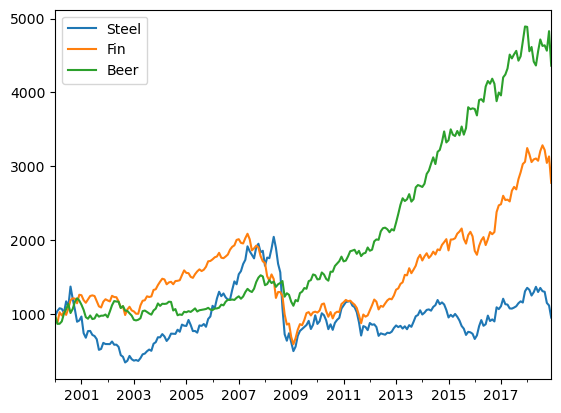

In [348]:
risky_wealth.plot()

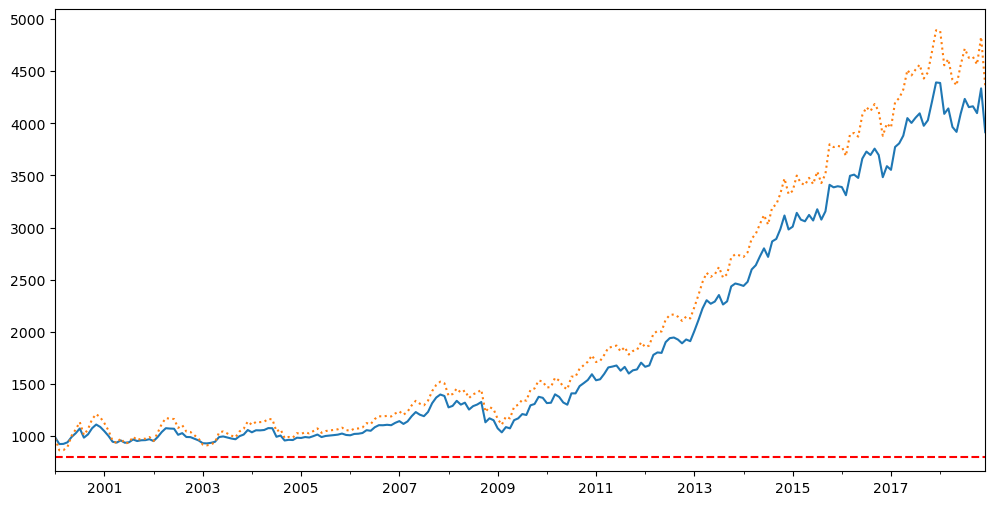

In [349]:
#Let's look at the Beer
ax= account_history['Beer'].plot(figsize=(12,6))
ax= risky_wealth['Beer'].plot(style=':')
ax.axhline(y=floor_value, color='red',linestyle='--')

<AxesSubplot:>

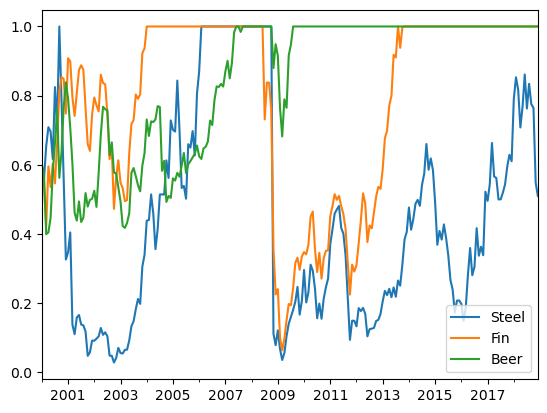

In [350]:
#The weights allocation history
risky_w_history.plot()

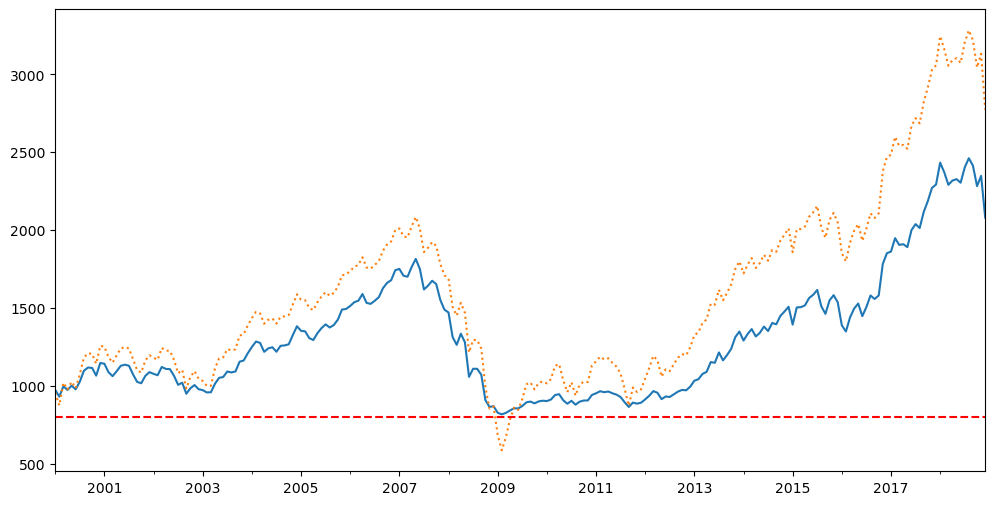

In [351]:
#Take a look at Finance 
ax= account_history['Fin'].plot(figsize=(12,6))
ax= risky_wealth['Fin'].plot(style=':')
ax.axhline(y=floor_value, color='red',linestyle='--')

In 2008 the Finance industry crashed. If we had been invested in Finance, you would have ended up piercing our floor.   
We can see blue line is very deftly bouncing off the crashed at this period.

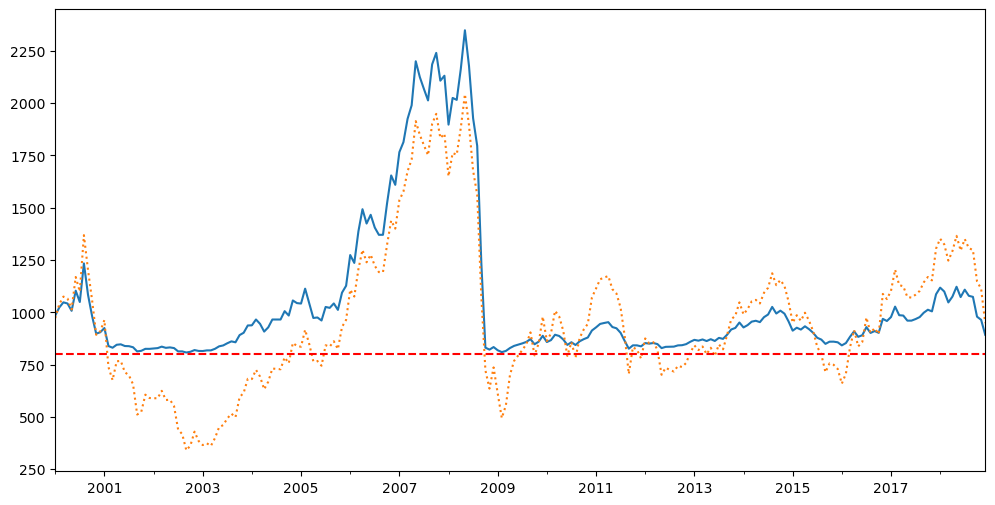

In [352]:
#Take a look at Steel
ax= account_history['Steel'].plot(figsize=(12,6))
ax= risky_wealth['Steel'].plot(style=':')
ax.axhline(y=floor_value, color='red',linestyle='--')

In the steel industry it's even more dramatic.  
We can see CPPI can let our portfolio perform less volatile and protects assets value from breaching the floor. 

Next, we put the above into our module kit file and called this function run_cppi().

In [353]:
#The summary stats of these 3 assets
rk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [354]:
#Backtest result
btr= rk.run_cppi(risky_r)
rk.summary_stats(btr['Wealth'].pct_change().dropna())# Convert wealth back to return and dropna() since we must have NA value in the first index

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


<AxesSubplot:>

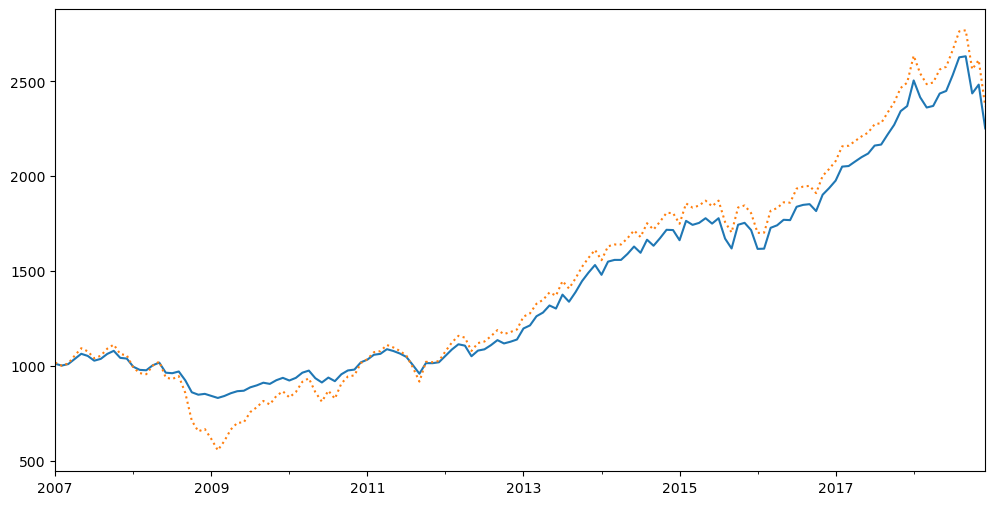

In [355]:
#Total Market Index returns after 2007
btr= rk.run_cppi(tmi_return['2007':])
ax= btr['Wealth'].plot(figsize=(12,6), legend= False)
btr['Risky Wealth'].plot(ax=ax, style=':', legend= False)

In [356]:
rk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [357]:
rk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


The drawdown has a significant improvement when applying CPPI.

### Drawdwon Constraint

<AxesSubplot:>

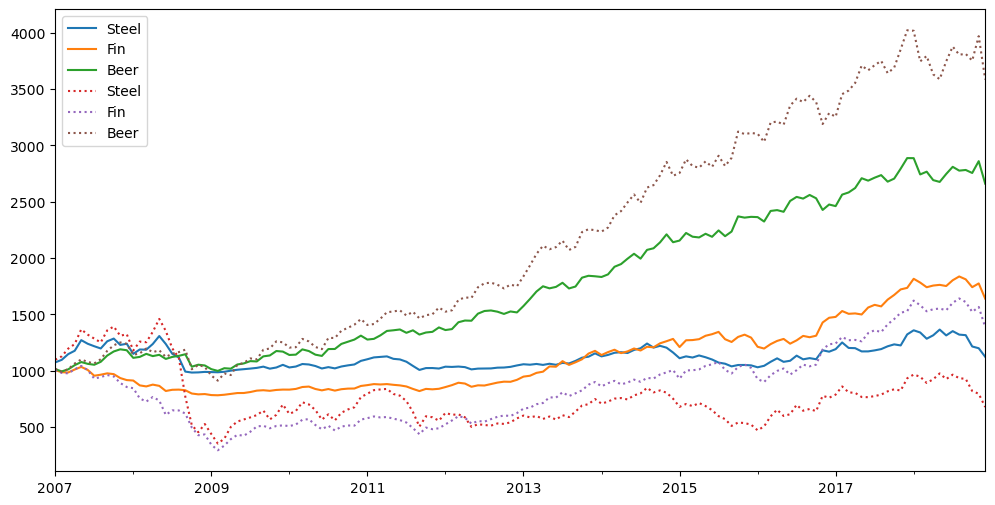

In [358]:
btr= rk.run_cppi(ind_return['2007':][['Steel', 'Fin', 'Beer']], drawdown= 0.25)
ax= btr['Wealth'].plot(figsize=(12,6))
btr['Risky Wealth'].plot(ax=ax, style=(':'))

In [359]:
rk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [360]:
#Since we've applied a drawdown constraint, the drawdown of the stats with CPPI strategy should be <0.25 
rk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186
